# First  EDA

Table of contents <a id='top'>

1. [Portfolio](#portfolio)
2. [Profile](#profile)
3. [Transcript](#transcript)

In [274]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime as dt

DATA_RAW = '../../data/raw'

# read in the json files
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

## Portfolio <a id='portfolio'></a>
[Top](#top)

In [275]:
print(portfolio.shape)
portfolio.sort_values(by='offer_type')

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


Let's change the "channels" column.

In [276]:
def channels_ohe(portfolio):
    """
    Transforms the 'channels' column of the 'portfolio' dataframe into One-Hot 
    encoded columns for the possible channels.
    """
    # Get all the possible channels
    possible_channels = set()
    for c_list in portfolio.channels:
        for channel in c_list:
            possible_channels.add(channel)
    possible_channels = list(possible_channels)
    
    # Create the channels' columns and fill them
    for channel in possible_channels:
        portfolio['channel_' + channel] = portfolio.channels.apply(
            lambda x: int(channel in x))
    
    # Drop the old "channels" column
    portfolio = portfolio.drop('channels', axis=1)

    return portfolio

In [277]:
portfolio = channels_ohe(portfolio)
portfolio

,difficulty,duration,id,offer_type,reward,channel_social,channel_web,channel_email,channel_mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,0,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,1,1


## Profile <a id='profile'></a>
[Top](#top)

In [278]:
print(profile.shape)
profile.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [279]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [280]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

The age = 118 looks strange

In [281]:
profile.age.value_counts()[:10]

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
Name: age, dtype: int64

It's almost sure that 118 was the value used for NaNs in the age. It also seems likely that the customers that have any missing data, have all the 'profile' data missing. Let's test that.

In [282]:
profile.age = profile.age.replace(118, np.nan)

In [283]:
profile.isnull().sum(axis=1).unique()

array([3, 0])

That means that customers have 3 missing values or none, as supposed earlier.

Let's separate the customers in those who have missing data and those who don't. If a customer has all its profile missing, and doesn't have any entry in the transcript dataframe, then it should be ignored (as we don't have any information of use about the client). Are there any of those?

In [284]:
profile['missing_demographics'] = profile.isnull().any(axis=1).astype(int)
profile.head()

,age,became_member_on,gender,id,income,missing_demographics
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,1


In [285]:
utils.common_values(profile.id, transcript.person)

Intersection: 17000
Total set 1: 17000
Not in set 2: 0
Total set 2: 17000
Not in set 1: 0
Total: 17000


All the customers in the "profile" dataframe are in the "transcript" dataframe also. That means all customers give at least some information, and cannot be dropped.

### Let's transform the dates

In [286]:
profile.became_member_on = pd.to_datetime(profile.became_member_on, 
                                          format='%Y%m%d')
profile.head()

,age,became_member_on,gender,id,income,missing_demographics
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,1


### And encode the gender

In [287]:
gender_dict = {'F': 0, 'M': 1, 'O': 2, None: np.nan}
gender_dict_inverse = {0: 'F', 1: 'M', 2: 'O', np.nan: None}
profile.gender = profile.gender.replace(gender_dict)
profile.head()

,age,became_member_on,gender,id,income,missing_demographics
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1
1,55.0,2017-07-15,0.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,NaN,2018-07-12,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,NaN,2017-08-04,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1


In [288]:
profile.gender.replace(gender_dict_inverse).head()

0    None
1       F
2    None
3       F
4    None
Name: gender, dtype: object

### Let's find a good format to use the dates in the estimators

In [289]:
profile['member_since_epoch'] = (
    profile.became_member_on - dt.datetime(1970,1,1)).dt.days
profile.head()

,age,became_member_on,gender,id,income,missing_demographics,member_since_epoch
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1,17209
1,55.0,2017-07-15,0.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,17362
2,NaN,2018-07-12,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,1,17724
3,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,17295
4,NaN,2017-08-04,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1,17382


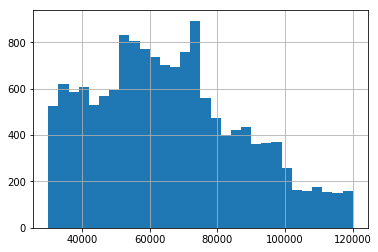

In [290]:
profile.income.hist(bins=30)

In [291]:
profile.gender.value_counts(dropna=False)

 1.0    8484
 0.0    6129
NaN     2175
 2.0     212
Name: gender, dtype: int64

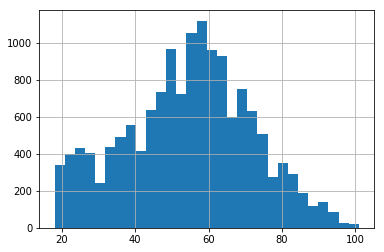

In [292]:
profile.age.hist(bins=30)

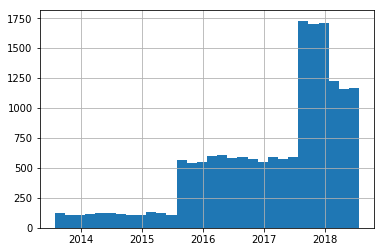

In [293]:
profile.became_member_on.hist(bins=30)

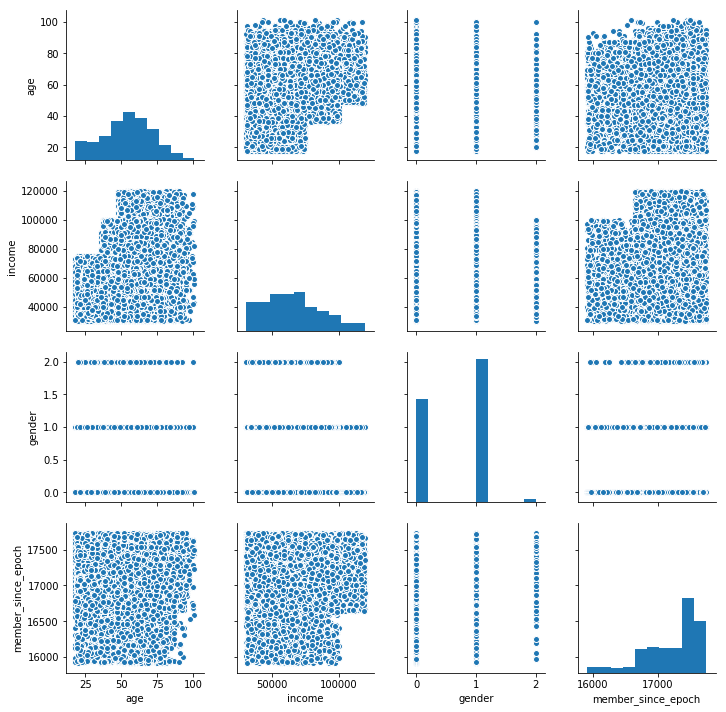

In [294]:
sns.pairplot(profile[['age', 
                      'income', 
                      'gender', 
                      'member_since_epoch']].dropna())

There is a very strange age-income "stair"... but, after all, this is simulated data.

**Finding:** The simulator seems to cap the income for younger customers, in discrete steps.

## Transcript <a id='transcript'></a>
[Top](#top)

In [295]:
print(transcript.shape)
transcript.head()

(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [296]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [297]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [298]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

Let's check the different values, for each type of event.

In [299]:
def unwrap_transcript(transcript):
    """ Reads the 'value' dictionaries and adds the values as columns. """
    values_df = pd.DataFrame(transcript.value.tolist())
    values_df.offer_id.update(values_df['offer id'])
    values_df = values_df.drop('offer id', axis=1)

    return transcript.join(values_df).drop('value', axis=1)

In [300]:
transcript = unwrap_transcript(transcript)

In [301]:
transcript[transcript.event == 'offer received'].head()

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [302]:
transcript[transcript.event == 'offer viewed'].head()

,event,person,time,amount,offer_id,reward
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN


In [303]:
transcript[transcript.event == 'transaction'].head()

,event,person,time,amount,offer_id,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN


In [304]:
transcript[transcript.event == 'offer completed'].head()

,event,person,time,amount,offer_id,reward
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


The "event" column could be Label-encoded but, other than that, there don't seem to be many simple preprocessing actions to take. There is still a lot of data wrangling before having a well posed problem, though.

Let's make a dataset that doesn't take into account the particular person or offer, but rather their features.

In [305]:
profile.head()

,age,became_member_on,gender,id,income,missing_demographics,member_since_epoch
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1,17209
1,55.0,2017-07-15,0.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,17362
2,NaN,2018-07-12,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,1,17724
3,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,17295
4,NaN,2017-08-04,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1,17382


In [306]:
portfolio

,difficulty,duration,id,offer_type,reward,channel_social,channel_web,channel_email,channel_mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,0,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,1,1


In [316]:
def join_data(transcript, profile, portfolio, static=True):
    """ 
    Joins the three sources of data in one dataframe.
    Args:
        transcript(pandas dataframe): Contains the events (part of the raw 
            data)
        profile(pandas dataframe): Contains the customer's profiles (part of 
            the raw data)
        portfolio(pandas dataframe): Contains the offers (part of the raw data)
        static(boolean): If True, remove the customer and offer ids. Otherwise
            keep them for a possible time-dependent analysis.
    """
    merged_df = transcript.merge(profile, left_on='person', right_on='id', 
                                 how='left').drop('id', axis=1)
    merged_df = merged_df.merge(
        portfolio.rename(columns={'reward': 'reward_t'}),
        left_on='offer_id', right_on='id', how='left').drop('id', axis=1)
    if static:
        merged_df = merged_df.drop(['person', 'offer_id'], axis=1)
    
    return merged_df

In [318]:
static_df = join_data(transcript, profile, portfolio)
static_df.head()

,event,time,amount,reward,age,became_member_on,gender,income,missing_demographics,member_since_epoch,difficulty,duration,offer_type,reward_t,channel_social,channel_web,channel_email,channel_mobile
0,offer received,0,NaN,NaN,75.0,2017-05-09,0.0,100000.0,0,17295,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0
1,offer received,0,NaN,NaN,NaN,2017-08-04,NaN,NaN,1,17382,20.0,10.0,discount,5.0,0.0,1.0,1.0,0.0
2,offer received,0,NaN,NaN,68.0,2018-04-26,1.0,70000.0,0,17647,10.0,7.0,discount,2.0,0.0,1.0,1.0,1.0
3,offer received,0,NaN,NaN,NaN,2017-09-25,NaN,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,0,NaN,NaN,NaN,2017-10-02,NaN,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [320]:
static_df = static_df.drop('became_member_on', axis=1)

In [321]:
static_df.duration.unique()

array([ 7., 10.,  5.,  4.,  3., nan])

### Let's check how often offers are sent to customers, and if they are coordinated.

In [324]:
merged_df = join_data(transcript, profile, portfolio, False)
merged_df.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_since_epoch,difficulty,duration,offer_type,reward_t,channel_social,channel_web,channel_email,channel_mobile
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,0.0,100000.0,0,17295,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,NaN,NaN,1,17382,20.0,10.0,discount,5.0,0.0,1.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,1.0,70000.0,0,17647,10.0,7.0,discount,2.0,0.0,1.0,1.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,NaN,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,NaN,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [328]:
sent = merged_df[merged_df.event == 'offer received']

In [331]:
usr = sent[merged_df.person == merged_df.person[0]]
usr.head()

/Users/antelinvestigacionydesarrollo/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_since_epoch,difficulty,duration,offer_type,reward_t,channel_social,channel_web,channel_email,channel_mobile
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,0.0,100000.0,0,17295,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,75.0,2017-05-09,0.0,100000.0,0,17295,0.0,3.0,informational,0.0,1.0,0.0,1.0,1.0
150598,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,75.0,2017-05-09,0.0,100000.0,0,17295,10.0,7.0,bogo,10.0,1.0,0.0,1.0,1.0
201572,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,75.0,2017-05-09,0.0,100000.0,0,17295,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0


In [333]:
usr.time - usr.time.shift(1)

0           NaN
53176     168.0
150598    240.0
201572     96.0
Name: time, dtype: float64

In [342]:
def get_differences(user_events):
    return pd.DataFrame((user_events.time - user_events.time.shift(1)).values)

In [348]:
delays = sent.groupby('person').apply(get_differences).rename(
    columns={0: 'diff'})

In [349]:
delays.head()

diff
person                                   
0009655768c64bdeb2e877511632db8f 0    NaN
                                 1  168.0
                                 2   72.0
                                 3   96.0
                                 4   72.0

In [352]:
delays = delays.unstack()
delays.head()

diff                              
                                    0      1      2     3     4   5
person                                                             
0009655768c64bdeb2e877511632db8f  NaN  168.0   72.0  96.0  72.0 NaN
00116118485d4dfda04fdbaba9a87b5c  NaN  408.0    NaN   NaN   NaN NaN
0011e0d4e6b944f998e987f904e8c1e5  NaN  168.0  168.0  72.0  96.0 NaN
0020c2b971eb4e9188eac86d93036a77  NaN  168.0  168.0  72.0  96.0 NaN
0020ccbbb6d84e358d3414a3ff76cffd  NaN  168.0   72.0  96.0   NaN NaN

In [356]:
diffs = delays.values.flatten()
print(diffs.shape)
diffs = diffs[~np.isnan(diffs)]
print(diffs.shape)

(101964,)
(59283,)


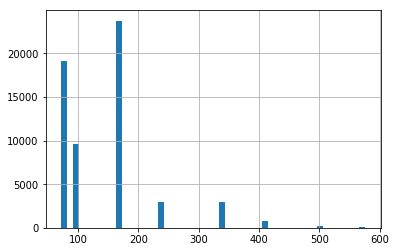

In [359]:
diffs = pd.Series(diffs)
diffs.hist(bins=50)

In [361]:
diffs.value_counts()

168.0    23754
72.0     19109
96.0      9557
336.0     2942
240.0     2908
408.0      810
504.0      156
576.0       47
dtype: int64

In [365]:
d_vals = diffs.sort_values().unique()
d_vals

array([ 72.,  96., 168., 240., 336., 408., 504., 576.])

In [368]:
d_vals[1:] - d_vals[:-1]

array([24., 72., 72., 96., 72., 96., 72.])

### The sending of offers is clearly coordinated, and sent in very specific times. The times are multiples of 24. Let's investigate further.

In [373]:
times = sent.groupby('person').apply(lambda x: pd.DataFrame(x.time.values)).rename(
    columns={0: 'times'})

In [374]:
times.head()

times
person                                   
0009655768c64bdeb2e877511632db8f 0    168
                                 1    336
                                 2    408
                                 3    504
                                 4    576

In [376]:
tt = times.unstack()
tt.head()

times                                
                                      0      1      2      3      4   5
person                                                                 
0009655768c64bdeb2e877511632db8f  168.0  336.0  408.0  504.0  576.0 NaN
00116118485d4dfda04fdbaba9a87b5c  168.0  576.0    NaN    NaN    NaN NaN
0011e0d4e6b944f998e987f904e8c1e5    0.0  168.0  336.0  408.0  504.0 NaN
0020c2b971eb4e9188eac86d93036a77    0.0  168.0  336.0  408.0  504.0 NaN
0020ccbbb6d84e358d3414a3ff76cffd  168.0  336.0  408.0  504.0    NaN NaN